In [1]:
import matplotlib.pyplot as plt
import numpy as np
#import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Dropout, LeakyReLU, ReLU, LayerNormalization, GaussianNoise
#from tensorflow.keras.layers import BatchNormalization
from tensorflow.compat.v1.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Activation, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose, MaxPooling2D
from keras import initializers
from math import ceil
import time
from tensorflow_addons.layers import SpectralNormalization

In [2]:
#Updated Versions
#Spectral Normalization Model
def build_cifar10_discriminator(image_shape=(32, 32, 3)):
    
    model = Sequential()
    
    #16 output filters, so number of channels jumps from 1 to 16
    #kernel_size = 5 means we use a 5x5 convolution window
    #strides defaults to (1,1) when unspecified, "same" padding means we'll preserve the image size
    model.add(Conv2D(16, kernel_size=5, strides=2, padding="same", input_shape=(32, 32, 3), 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))) #40
    model.add(LeakyReLU(0.2))
    model.add(SpectralNormalization(Conv2D(32, kernel_size=5, strides=2, padding="same", 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(0.2))
    
    #Second layer
    model.add(SpectralNormalization(Conv2D(64, kernel_size=5, strides=2, padding="same", 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(0.2))
    model.add(SpectralNormalization(Conv2D(128, kernel_size=5, strides=2, padding="same", 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(0.2))

    #Flatten for Final Output Layer
    model.add(Flatten())

    #Output layer
    model.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(Activation("sigmoid"))
    
    #Final Output
    print("\nDiscriminator")
    model.summary()
    return model




#Spectral Normalization Model
def build_cifar10_generator(z_dim=100):
    
    model = Sequential()
    
    #First Layer (4x4)
    model.add(Dense(4*4*128, input_dim=z_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(Reshape((4,4,128)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 8x8
    model.add(SpectralNormalization(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', 
                              use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 16x16
    model.add(SpectralNormalization(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', 
                              use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 32x32
    model.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same',
          use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    
    # output layer
    model.add(Activation('tanh'))

    print("\nGenerator")
    model.summary()
    return model




#Build and Compile Networks
#Variables
#Loss Functions:  Don't seem to matter for performance, any choice will work
#Learning rates:  Trying higher learning rate for Discriminator;  
#Discriminator is easier to succeed, gives generator a better chance at competition, prevents mode collapse
lr_d=2e-4
lr_g=1e-4
z_dim=100
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
image_shape = X_train[0].shape

D = build_cifar10_discriminator(image_shape)
G = build_cifar10_generator(z_dim)

D.compile(Adam(learning_rate=lr_d, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
D.trainable = False

z = Input(shape=(z_dim, ))
D_of_G = Model(inputs=z, outputs=D(G(z)))
D_of_G.compile(Adam(learning_rate=lr_g, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])


Discriminator
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 16)        1216      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 16)        0         
                                                                 
 spectral_normalization (Spe  (None, 8, 8, 32)         12864     
 ctralNormalization)                                             
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 32)          0         
                                                                 
 spectral_normalization_1 (S  (None, 4, 4, 64)         51328     
 pectralNormalization)                                           
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4,

In [3]:
#Function for plotting images
def plot_images(images, filename):
    h, w, c = images.shape[1:]
    #images = (1/(2*2.25)) * images + 0.5
    images = 0.5 * images + 0.5
    grid_size = ceil(np.sqrt(images.shape[0]))
    images = (images.reshape(grid_size, grid_size, h, w, c)
              .transpose(0, 2, 1, 3, 4)
              .reshape(grid_size*h, grid_size*w, c))
    plt.figure(figsize=(16, 16))
    plt.imsave(filename, images)
    
#Function for Plotting Losses During Training
def plot_losses(losses_d, losses_g, filename):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(losses_d)
    axes[1].plot(losses_g)
    axes[0].set_title("losses_d")
    axes[1].set_title("losses_g")
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    #plt.close()
    
#Functions for smoothing labels of 1 and 0
# Smoothing class=1 to [0.8, 1.0]
def smooth_positive_labels(y):
    return y - 0.2 + (np.random.random(y.shape) * 0.2)

# Smoothing class=0 to [0.0, 0.1]
def smooth_negative_labels(y):
    return y + (np.random.random(y.shape) * 0.1)

#Function for generating latent points to feed into generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
     x_input = np.random.randn(latent_dim * n_samples)
     # reshape into a batch of inputs for the network
     x_input = x_input.reshape((n_samples, latent_dim))
     return x_input
    

#Function for adding noise to images
#  Adding noise to images prevents discriminator overfitting, inhibits performance to allow
#   for better rivalry with the generator (which is generally slower to train)
#This function adds 'salt and pepper noise' (randomly set pixels to either -1 or 1) 
# def noisy(image):
#     row,col,ch = image.shape
#     s_vs_p = 0.5
#     amount = 0.004
#     out = np.copy(image)
#     # Salt mode
#     num_salt = np.ceil(amount * image.size * s_vs_p)
#     coords = tuple([np.random.randint(0, i - 1, int(num_salt))
#             for i in image.shape])
#     out[coords] = 1

#     # Pepper mode
#     num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
#     coords = tuple([np.random.randint(0, i - 1, int(num_pepper))
#             for i in image.shape])
#     out[coords] = -1
#     return out

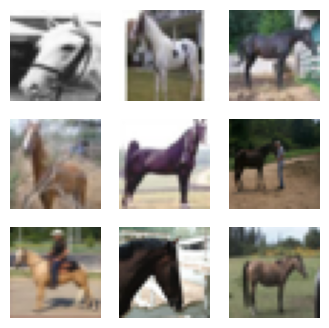

In [4]:
# #Test only grabbing images of one type

#Load the CIFAR10 data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
#Concatenate X_train and X_test for more data
X_train = np.concatenate((X_train,X_test))
y_train = np.concatenate((y_train,y_test))
#Only use index 0, AKA Airplanes
index = np.where(y_train.reshape(-1) == 7)
X_train = X_train[index]
y_train = y_train[index]

#Testing to make sure it's just airplanes
fig,axs = plt.subplots(3,3,figsize=(4,4),sharey=True,sharex=True)
cnt=0
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(X_train[-9:][cnt,:,:])
        axs[i, j].axis('off')
        cnt+=1

image shape (32, 32, 3), min val -0.929411768913269, max val 0.9450980424880981
Epoch 0
Time for epoch:  27.776519536972046
loss_d=0.31872, loss_g=1.57777
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

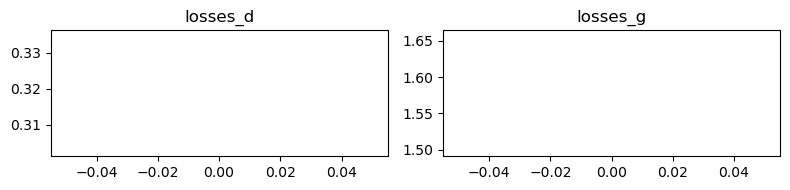

Epoch 1
Time for epoch:  23.865710735321045
Epoch 2
Time for epoch:  23.897908926010132
Epoch 3
Time for epoch:  24.413989067077637
Epoch 4
Time for epoch:  22.56029748916626
Epoch 5
Time for epoch:  22.466201066970825
loss_d=0.58313, loss_g=0.90070
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


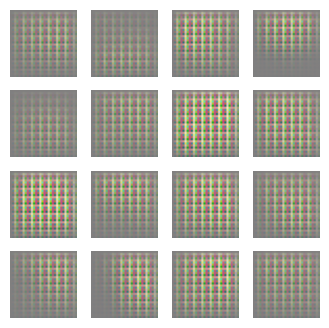

<Figure size 1600x1600 with 0 Axes>

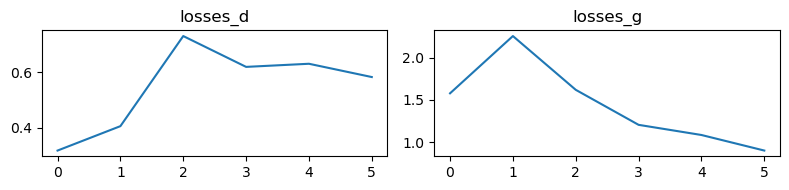

Epoch 6
Time for epoch:  22.510815143585205
Epoch 7
Time for epoch:  22.5020112991333
Epoch 8
Time for epoch:  22.68470025062561
Epoch 9
Time for epoch:  22.808321475982666
Epoch 10
Time for epoch:  22.594654083251953
loss_d=0.59343, loss_g=1.00881
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


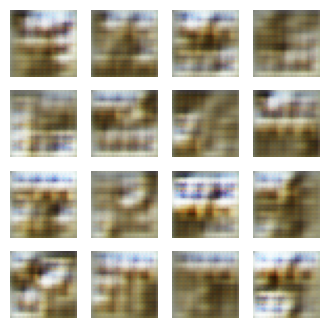

<Figure size 1600x1600 with 0 Axes>

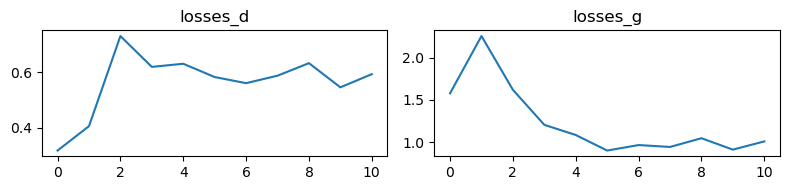

Epoch 11
Time for epoch:  22.543088674545288
Epoch 12
Time for epoch:  22.500290155410767
Epoch 13
Time for epoch:  22.621684312820435
Epoch 14
Time for epoch:  22.809062242507935
Epoch 15
Time for epoch:  22.564728021621704
loss_d=0.59700, loss_g=0.97992
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


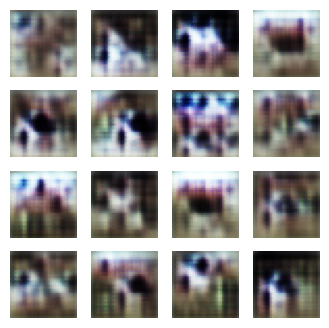

<Figure size 1600x1600 with 0 Axes>

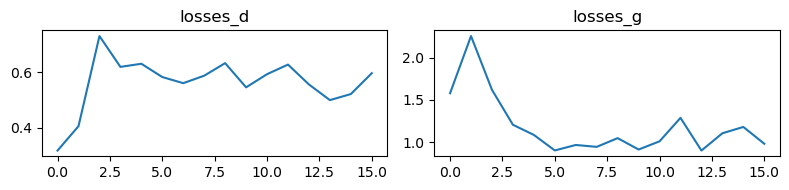

Epoch 16
Time for epoch:  22.4192316532135
Epoch 17
Time for epoch:  22.56051516532898
Epoch 18
Time for epoch:  22.42958378791809
Epoch 19
Time for epoch:  22.398189544677734
Epoch 20
Time for epoch:  22.41860580444336
loss_d=0.51104, loss_g=1.43603
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


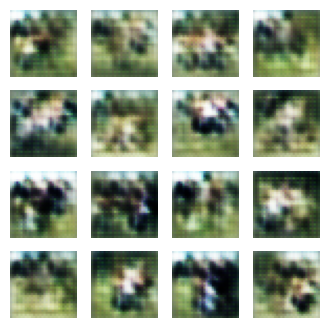

<Figure size 1600x1600 with 0 Axes>

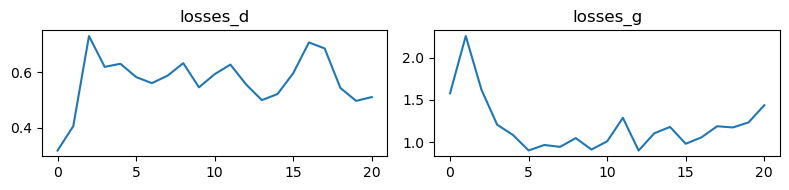

Epoch 21
Time for epoch:  22.732135772705078
Epoch 22
Time for epoch:  22.584052562713623
Epoch 23
Time for epoch:  22.71370029449463
Epoch 24
Time for epoch:  22.708468437194824
Epoch 25
Time for epoch:  22.65246891975403
loss_d=0.47589, loss_g=1.44724
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


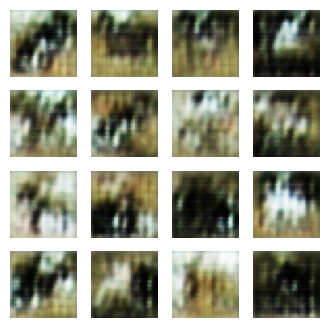

<Figure size 1600x1600 with 0 Axes>

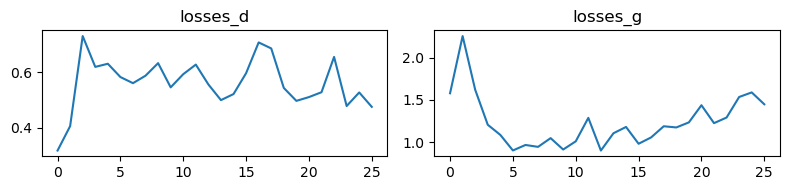

Epoch 26
Time for epoch:  22.40215563774109
Epoch 27
Time for epoch:  22.422226190567017
Epoch 28
Time for epoch:  22.48939800262451
Epoch 29
Time for epoch:  22.710468530654907
Epoch 30
Time for epoch:  22.491429328918457
loss_d=0.52304, loss_g=1.58558
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


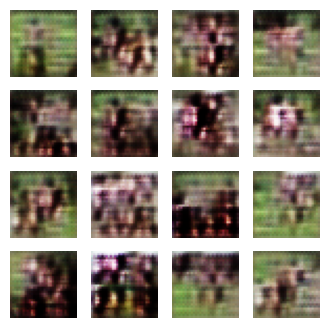

<Figure size 1600x1600 with 0 Axes>

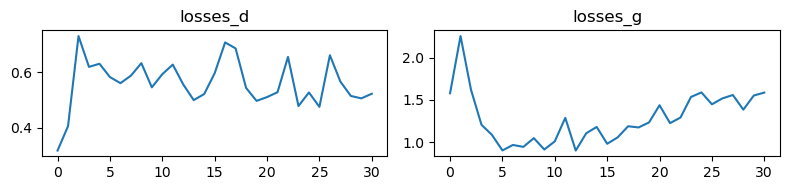

Epoch 31
Time for epoch:  22.425405263900757
Epoch 32
Time for epoch:  22.41318440437317
Epoch 33
Time for epoch:  22.502598524093628
Epoch 34
Time for epoch:  22.48052191734314
Epoch 35
Time for epoch:  22.435587406158447
loss_d=0.60098, loss_g=1.30661
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


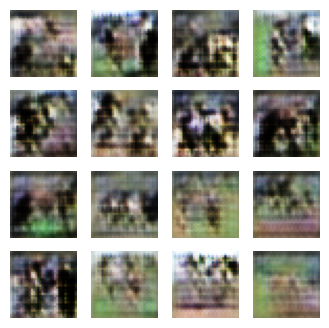

<Figure size 1600x1600 with 0 Axes>

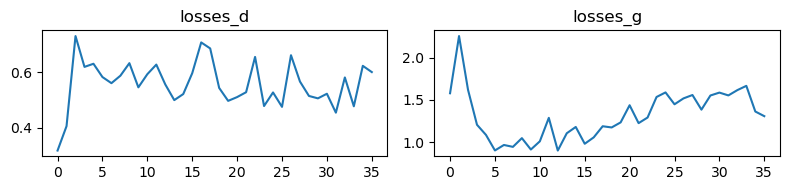

Epoch 36
Time for epoch:  22.58179020881653
Epoch 37
Time for epoch:  22.495276927947998
Epoch 38
Time for epoch:  22.706968069076538
Epoch 39
Time for epoch:  22.511133193969727
Epoch 40
Time for epoch:  22.477571725845337
loss_d=0.55014, loss_g=1.27896
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


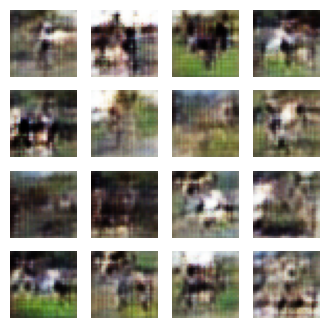

<Figure size 1600x1600 with 0 Axes>

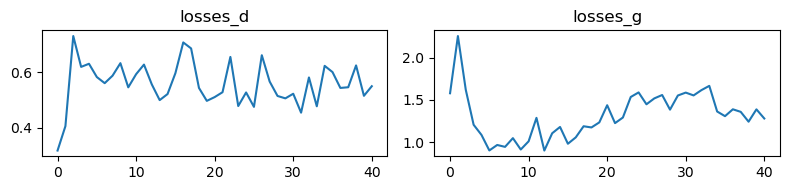

Epoch 41
Time for epoch:  22.40770649909973
Epoch 42
Time for epoch:  22.523409605026245
Epoch 43
Time for epoch:  22.982253551483154
Epoch 44
Time for epoch:  22.360471963882446
Epoch 45
Time for epoch:  22.44012188911438
loss_d=0.65572, loss_g=1.14656
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


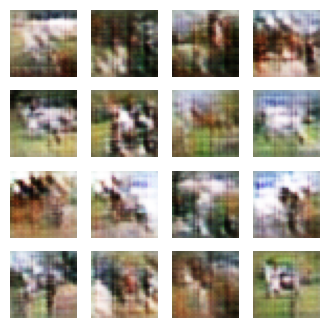

<Figure size 1600x1600 with 0 Axes>

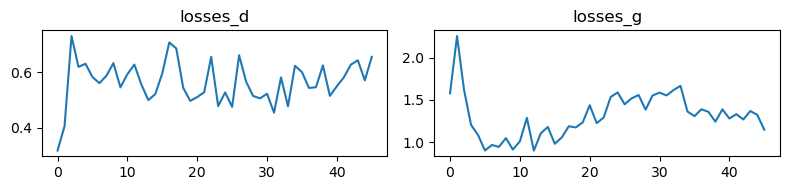

Epoch 46
Time for epoch:  22.255970239639282
Epoch 47
Time for epoch:  22.457616090774536
Epoch 48
Time for epoch:  22.18890619277954
Epoch 49
Time for epoch:  22.605363845825195
Epoch 50
Time for epoch:  22.270711660385132
loss_d=0.51732, loss_g=1.41880
2/2 [==============================] - 0s 3ms/step
	Plotting images and losses


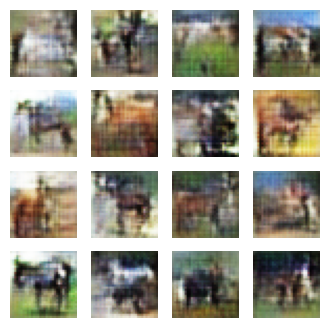

<Figure size 1600x1600 with 0 Axes>

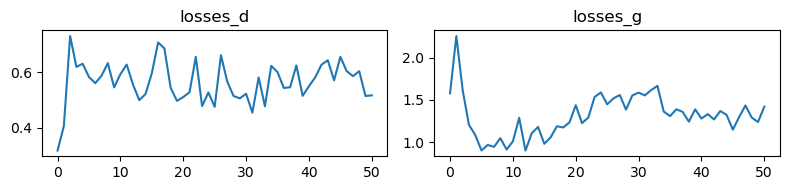

Epoch 51
Time for epoch:  22.368200302124023
Epoch 52
Time for epoch:  22.382843732833862
Epoch 53
Time for epoch:  22.523057460784912
Epoch 54
Time for epoch:  22.384966373443604
Epoch 55
Time for epoch:  22.442654848098755
loss_d=0.53291, loss_g=1.30718
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


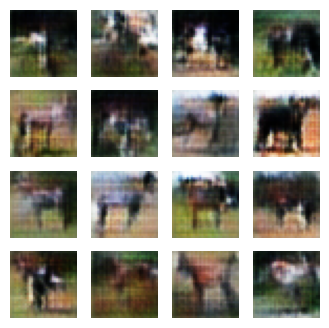

<Figure size 1600x1600 with 0 Axes>

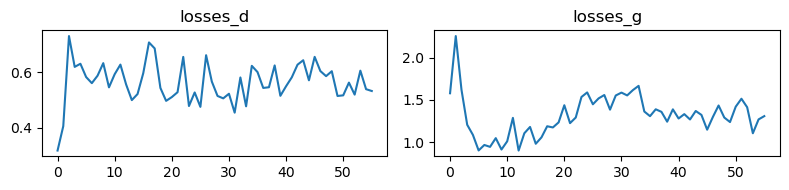

Epoch 56
Time for epoch:  22.2965350151062
Epoch 57
Time for epoch:  22.48292851448059
Epoch 58
Time for epoch:  22.255467891693115
Epoch 59
Time for epoch:  22.22604465484619
Epoch 60
Time for epoch:  22.296881198883057
loss_d=0.55855, loss_g=1.20600
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


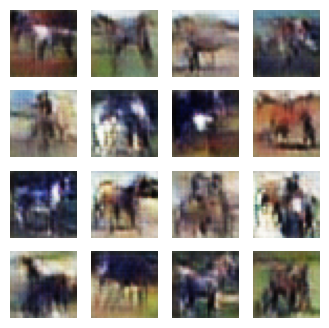

<Figure size 1600x1600 with 0 Axes>

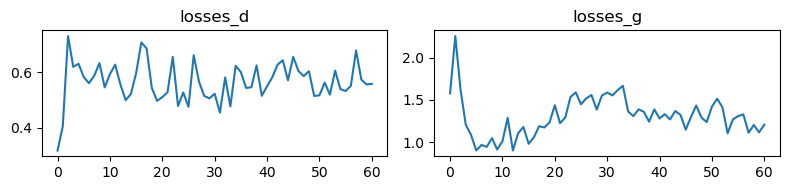

Epoch 61
Time for epoch:  22.560410022735596
Epoch 62
Time for epoch:  22.281851768493652
Epoch 63
Time for epoch:  22.288793563842773
Epoch 64
Time for epoch:  22.415476083755493
Epoch 65
Time for epoch:  22.376787662506104
loss_d=0.57543, loss_g=1.23381
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


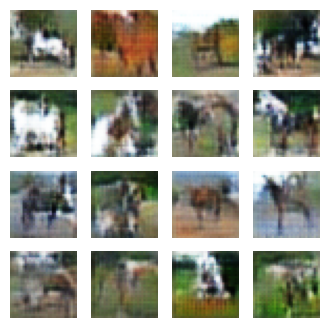

<Figure size 1600x1600 with 0 Axes>

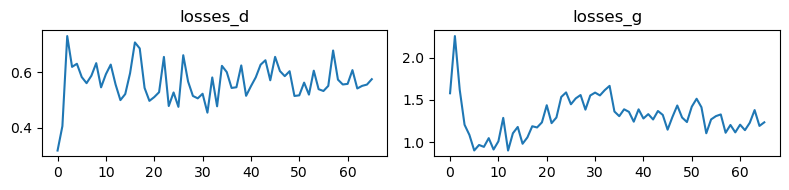

Epoch 66
Time for epoch:  22.351534128189087
Epoch 67
Time for epoch:  22.356550931930542
Epoch 68
Time for epoch:  22.32545566558838
Epoch 69
Time for epoch:  22.461844205856323
Epoch 70
Time for epoch:  22.443105220794678
loss_d=0.54930, loss_g=1.25374
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


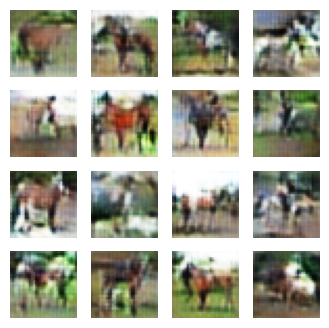

<Figure size 1600x1600 with 0 Axes>

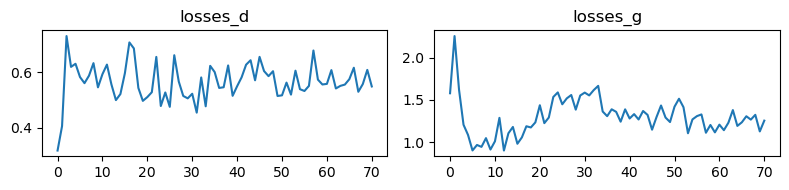

Epoch 71
Time for epoch:  22.318728923797607
Epoch 72
Time for epoch:  22.30455446243286
Epoch 73
Time for epoch:  22.38588809967041
Epoch 74
Time for epoch:  22.315168619155884
Epoch 75
Time for epoch:  22.317562341690063
loss_d=0.53603, loss_g=1.24342
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


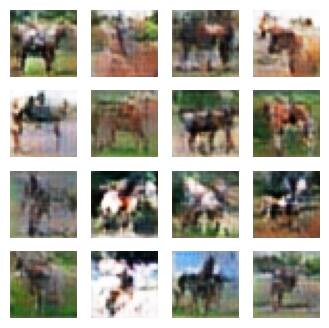

<Figure size 1600x1600 with 0 Axes>

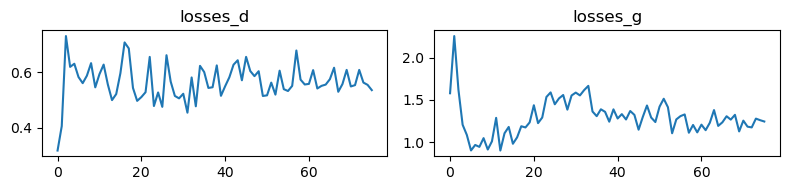

Epoch 76
Time for epoch:  22.400761604309082
Epoch 77
Time for epoch:  22.35928511619568
Epoch 78
Time for epoch:  22.68867588043213
Epoch 79
Time for epoch:  22.319392919540405
Epoch 80
Time for epoch:  22.328486919403076
loss_d=0.55478, loss_g=1.30343
2/2 [==============================] - 0s 3ms/step
	Plotting images and losses


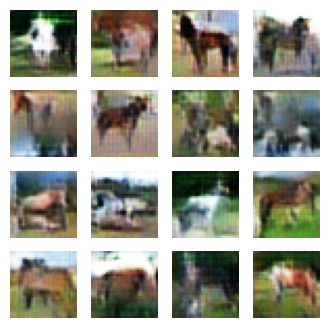

<Figure size 1600x1600 with 0 Axes>

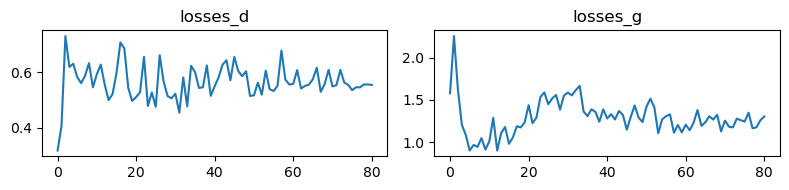

Epoch 81
Time for epoch:  22.484947204589844
Epoch 82
Time for epoch:  22.487406492233276
Epoch 83
Time for epoch:  22.458311557769775
Epoch 84
Time for epoch:  22.526259422302246
Epoch 85
Time for epoch:  22.524987936019897
loss_d=0.54490, loss_g=1.34099
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


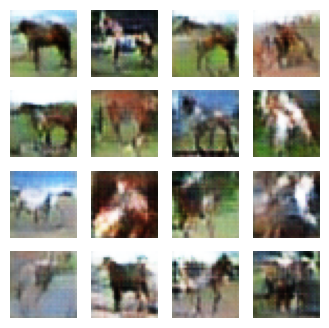

<Figure size 1600x1600 with 0 Axes>

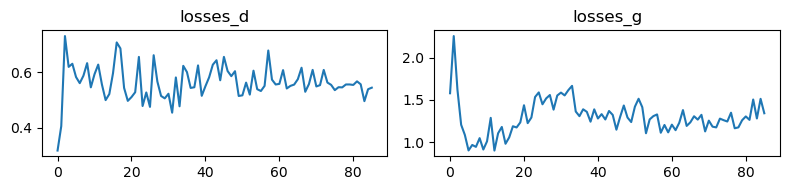

Epoch 86
Time for epoch:  22.57902193069458
Epoch 87
Time for epoch:  22.32020401954651
Epoch 88
Time for epoch:  22.311779022216797
Epoch 89
Time for epoch:  22.453681230545044
Epoch 90
Time for epoch:  22.33878755569458
loss_d=0.49662, loss_g=1.44213
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


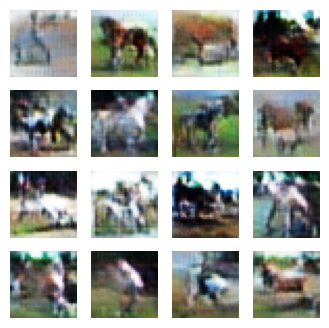

<Figure size 1600x1600 with 0 Axes>

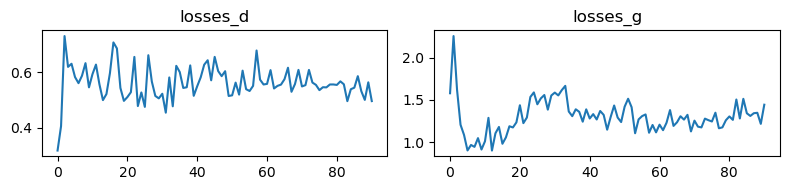

Epoch 91
Time for epoch:  22.332440614700317
Epoch 92
Time for epoch:  22.506991863250732
Epoch 93
Time for epoch:  22.557099103927612
Epoch 94
Time for epoch:  22.341190576553345
Epoch 95
Time for epoch:  22.366862535476685
loss_d=0.54019, loss_g=1.36964
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


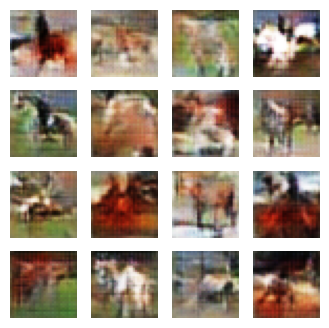

<Figure size 1600x1600 with 0 Axes>

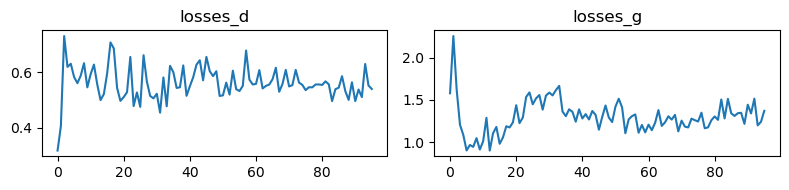

Epoch 96
Time for epoch:  22.521512746810913
Epoch 97
Time for epoch:  22.502437353134155
Epoch 98
Time for epoch:  22.441115140914917
Epoch 99
Time for epoch:  22.42338800430298
Epoch 100
Time for epoch:  22.47788405418396
loss_d=0.61487, loss_g=1.31415
2/2 [==============================] - 0s 3ms/step
	Plotting images and losses


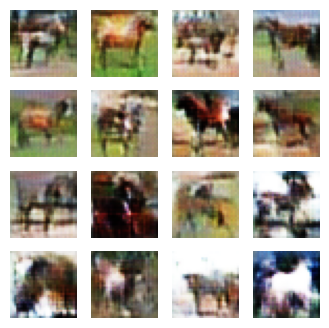

<Figure size 1600x1600 with 0 Axes>

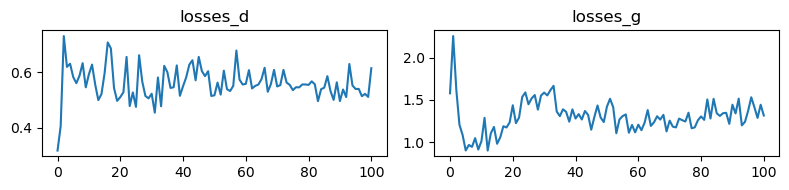

Epoch 101
Time for epoch:  22.619263410568237
Epoch 102
Time for epoch:  22.480902433395386
Epoch 103
Time for epoch:  22.43168592453003
Epoch 104
Time for epoch:  22.886372566223145
Epoch 105
Time for epoch:  22.45162868499756
loss_d=0.53086, loss_g=1.49411
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


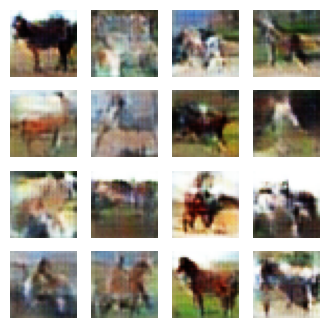

<Figure size 1600x1600 with 0 Axes>

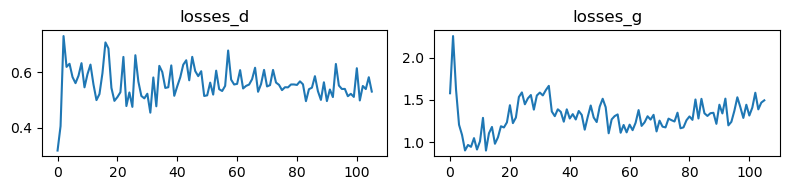

Epoch 106
Time for epoch:  22.46211862564087
Epoch 107
Time for epoch:  22.481889963150024
Epoch 108
Time for epoch:  22.44787836074829
Epoch 109
Time for epoch:  22.7259840965271
Epoch 110
Time for epoch:  22.55675983428955
loss_d=0.53583, loss_g=1.36676
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


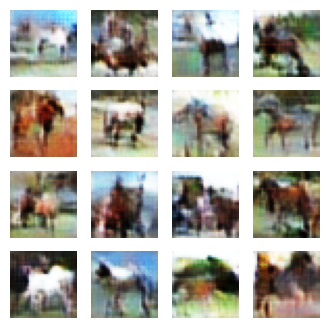

<Figure size 1600x1600 with 0 Axes>

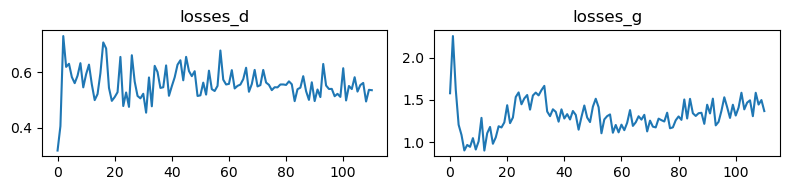

Epoch 111
Time for epoch:  22.6412091255188
Epoch 112
Time for epoch:  22.612194061279297
Epoch 113
Time for epoch:  22.64196491241455
Epoch 114
Time for epoch:  22.917561769485474
Epoch 115
Time for epoch:  22.675196647644043
loss_d=0.54482, loss_g=1.44603
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


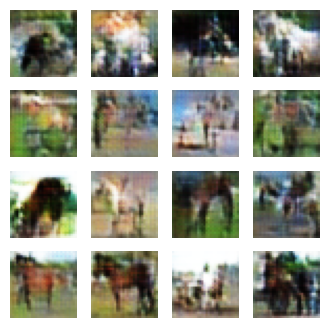

<Figure size 1600x1600 with 0 Axes>

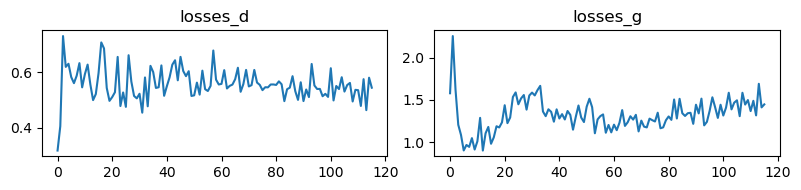

Epoch 116
Time for epoch:  22.72091031074524
Epoch 117
Time for epoch:  22.5460307598114
Epoch 118
Time for epoch:  22.97052812576294
Epoch 119
Time for epoch:  22.586097478866577
Epoch 120
Time for epoch:  22.61281657218933
loss_d=0.54412, loss_g=1.35679
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


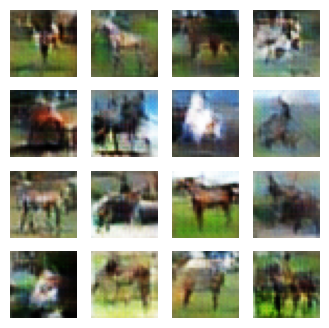

<Figure size 1600x1600 with 0 Axes>

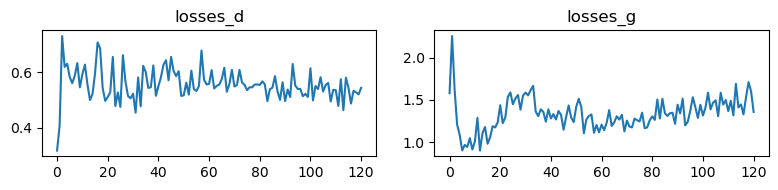

Epoch 121
Time for epoch:  22.48804521560669
Epoch 122
Time for epoch:  22.555501699447632
Epoch 123
Time for epoch:  22.574179649353027
Epoch 124
Time for epoch:  22.508219718933105
Epoch 125
Time for epoch:  22.604758262634277
loss_d=0.47542, loss_g=1.63139
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


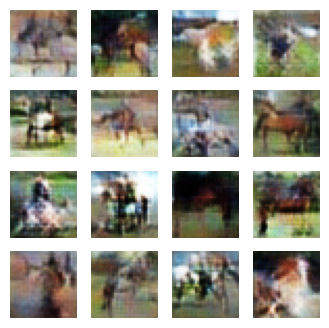

<Figure size 1600x1600 with 0 Axes>

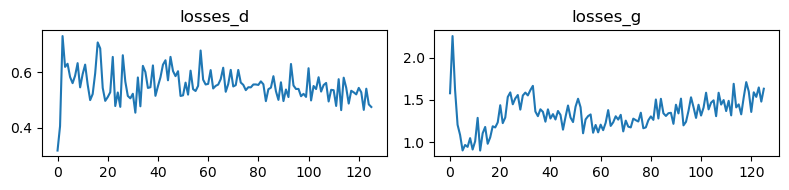

Epoch 126
Time for epoch:  23.124473333358765
Epoch 127
Time for epoch:  22.5400652885437
Epoch 128
Time for epoch:  22.500879049301147
Epoch 129
Time for epoch:  22.779890298843384
Epoch 130
Time for epoch:  22.534668684005737
loss_d=0.62770, loss_g=1.75901
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


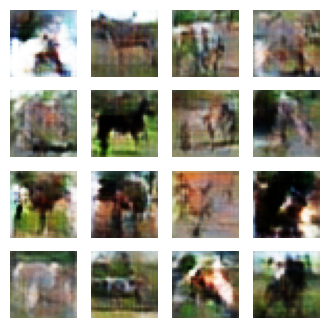

<Figure size 1600x1600 with 0 Axes>

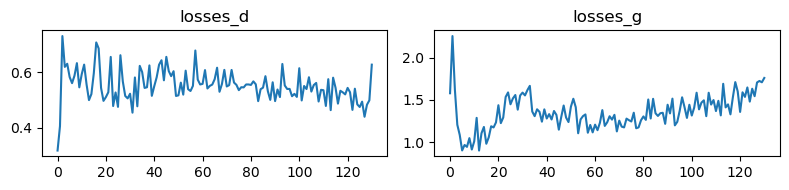

Epoch 131
Time for epoch:  22.52088952064514
Epoch 132
Time for epoch:  22.497424840927124
Epoch 133
Time for epoch:  22.641668796539307
Epoch 134
Time for epoch:  22.782989501953125
Epoch 135
Time for epoch:  22.544002056121826
loss_d=0.60236, loss_g=1.71862
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


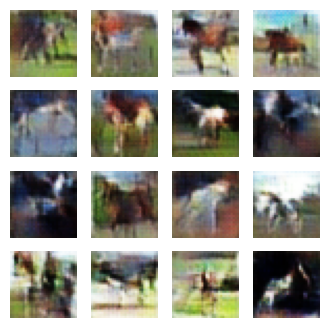

<Figure size 1600x1600 with 0 Axes>

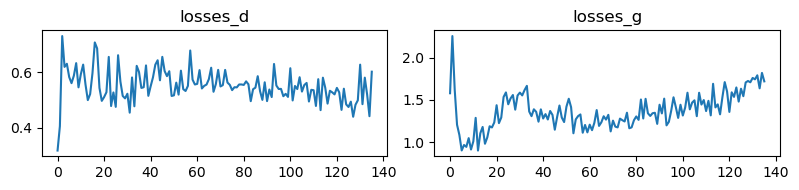

Epoch 136
Time for epoch:  22.48403024673462
Epoch 137
Time for epoch:  22.460494995117188
Epoch 138
Time for epoch:  22.44315195083618
Epoch 139
Time for epoch:  22.511539220809937
Epoch 140
Time for epoch:  22.498273134231567
loss_d=0.61571, loss_g=1.78580
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


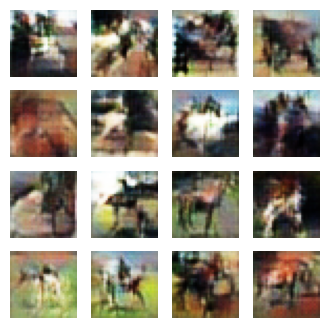

<Figure size 1600x1600 with 0 Axes>

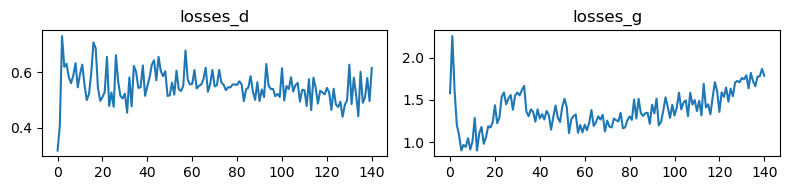

Epoch 141
Time for epoch:  22.882262468338013
Epoch 142
Time for epoch:  22.656570434570312
Epoch 143
Time for epoch:  22.80475640296936
Epoch 144
Time for epoch:  22.747233867645264
Epoch 145
Time for epoch:  22.687373399734497
loss_d=0.48006, loss_g=2.08009
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


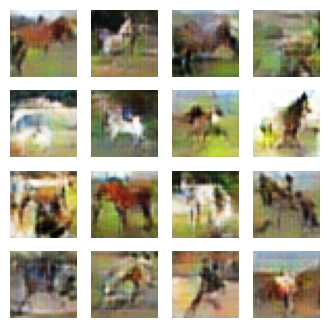

<Figure size 1600x1600 with 0 Axes>

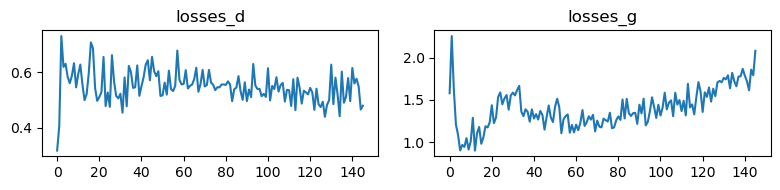

Epoch 146
Time for epoch:  22.537078142166138
Epoch 147
Time for epoch:  22.721222162246704
Epoch 148
Time for epoch:  22.669211387634277
Epoch 149
Time for epoch:  22.668946743011475


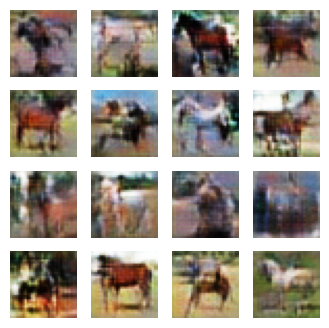

In [5]:
#Training Function
def train(z_dim=100, epochs=150,
          batch_size=16, epoch_per_checkpoint=5, n_checkpoint_images=36):

    #Load the CIFAR10 data
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    #Concatenate X_train and X_test for more data
    X_train = np.concatenate((X_train,X_test))
    y_train = np.concatenate((y_train,y_test))
    #Only grab horses
    index = np.where(y_train.reshape(-1) == 7)
    X_train = X_train[index]
    y_train = y_train[index]
    #Convert data to floats, Scale data to -1, 1
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    X_train = X_train/127.5 - 1.0
    
    
    #Get image shapes and values for reference
    image_shape = X_train[0].shape
    print("image shape {}, min val {}, max val {}".format(image_shape, X_train[0].min(), X_train[0].max()))
    #Plot real images for reference
    plot_images(X_train[:n_checkpoint_images], "real_images.png")


    #Get labels for computing the losses
    labels_real = np.ones(shape=(batch_size, 1)) 
    labels_fake = np.zeros(shape=(batch_size, 1))
    #Smooth labels to prevent mode collapse
    labels_real = smooth_positive_labels(labels_real)
    labels_fake = smooth_negative_labels(labels_fake)

    losses_d, losses_g = [], []

    
    # training loop
    for e in range(epochs):
        start = time.time()
        print("Epoch {}".format(e))
        for i in range(len(X_train) // batch_size):

            # update Discriminator weights
            D.trainable = True

            # Get real samples, train discriminator on them
            real_images = X_train[i*batch_size: (i+1)*batch_size]
            #Feed noisy images to discriminator
#             for j in range(batch_size):
#                 real_images[j] = noisy(real_images[j])
            loss_d_real = D.train_on_batch(x=real_images, y=labels_real)[0]

            # Make fake samples, train discriminator on them
            z = generate_latent_points(z_dim, batch_size)
            fake_images = G.predict_on_batch(z)
            #Feed noisy images to discriminator
#             for j in range(batch_size):
#                 fake_images[j] = noisy(fake_images[j])
            loss_d_fake = D.train_on_batch(x=fake_images, y=labels_fake)[0]

            # Compute Discriminator's loss
            loss_d = 0.5 * (loss_d_real + loss_d_fake)

#             # Train the generator while the discriminator is static
#             D.trainable = False
#             loss_g1 = D_of_G.train_on_batch(x=z, y=labels_real)[0]
#             # Update Generator again (train it twice as much as the Discriminator)
#             loss_g2 = D_of_G.train_on_batch(x=z, y=labels_real)[0]
            
#             # Compute Generator's loss
#             loss_g = 0.5 * (loss_g1 + loss_g2)
            # Train the generator while the discriminator is static
            D.trainable = False
            loss_g = D_of_G.train_on_batch(x=z, y=labels_real)[0]


        #Keep track of losses for plotting
        losses_d.append(loss_d)
        losses_g.append(loss_g)
        
        end = time.time()
        print("Time for epoch:  " + str(end-start))

        
        #Plot losses and generated images every X epochs
        if (e % epoch_per_checkpoint) == 0:
            print("loss_d={:.5f}, loss_g={:.5f}".format(loss_d, loss_g))
            
            # fix a z vector for training evaluation
            z_fixed = generate_latent_points(z_dim, n_checkpoint_images)
            
            fake_images = G.predict(z_fixed)
            print("\tPlotting images and losses")
            plot_images(fake_images, "fake_images_horses_e{}.png".format(e))
            plot_losses(losses_d, losses_g, "losses.png")
            
            #Show Images
            fake_images = (fake_images + 1) * 127.5
            fake_images = np.rint(fake_images)
            fake_images = fake_images.astype(int)

            fig,axs = plt.subplots(4,4,figsize=(4,4),sharey=True,sharex=True)
            cnt=0
            for k in range(4):
                for l in range(4):
                    axs[k, l].imshow(fake_images[cnt,:,:])
                    axs[k, l].axis('off')
                    cnt+=1

            #Save Model every 10 epochs
#             if (e % 10) == 0 and e != 0:
#                 print('Saving Models')
#                 D.save('./DiscriminatorModel')
#                 D_of_G.save('./CombinedModel')
            
            
train()

4/4 [==============================] - 0s 9ms/step


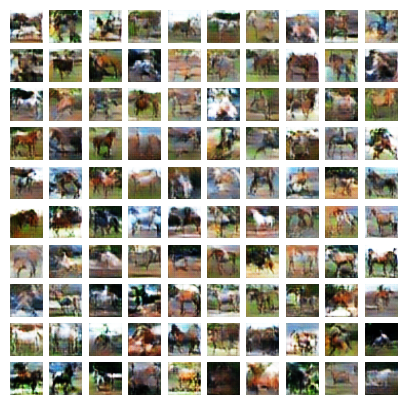

In [6]:
# #Print example images 
n_checkpoint_images = 100
z_dim = 100
#z_fixed = np.random.uniform(-1, 1, size=(n_checkpoint_images, z_dim))
z_fixed = generate_latent_points(z_dim, n_checkpoint_images)
fake_images = G.predict(z_fixed) #Predicted 'images' are (32,32,3) arrays with values -1 to 1
#Convert fake images into actual values for plotting (ints between 0 and 255)
fake_images = (fake_images + 1) * 127.5
fake_images = np.rint(fake_images)
fake_images = fake_images.astype(int)

fig,axs = plt.subplots(10,10,figsize=(5,5),sharey=True,sharex=True)
cnt=0
for k in range(10):
    for l in range(10):
        axs[k, l].imshow(fake_images[cnt,:,:])
        axs[k, l].axis('off')
        cnt+=1

4/4 [==============================] - 0s 11ms/step


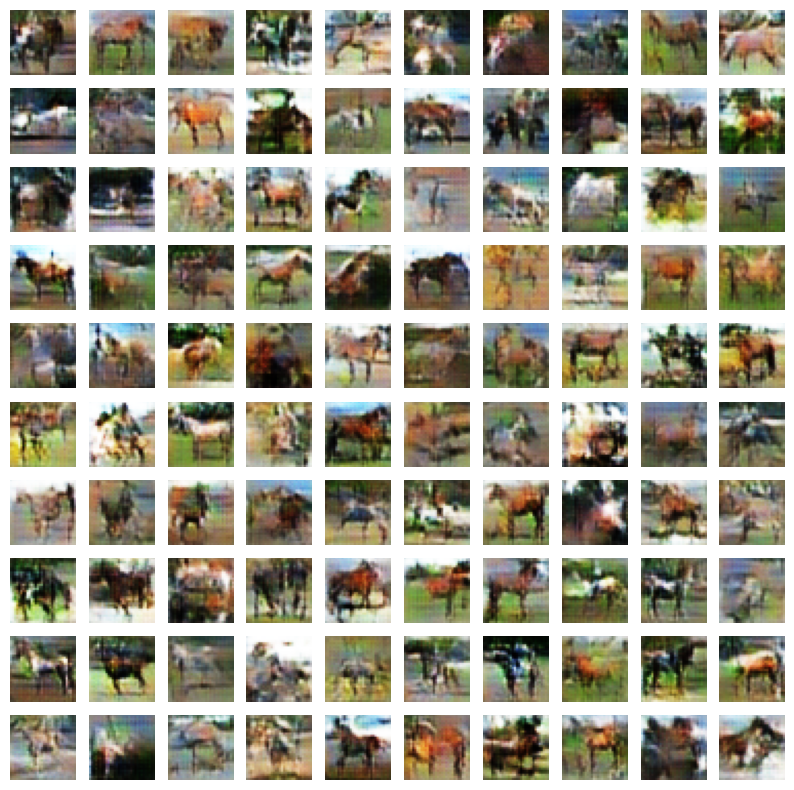

In [13]:
# #Print example images 
#Default Sets, 250 epochs
n_checkpoint_images = 100
z_dim = 100
#z_fixed = np.random.uniform(-1, 1, size=(n_checkpoint_images, z_dim))
z_fixed = generate_latent_points(z_dim, n_checkpoint_images)
fake_images = G.predict(z_fixed) #Predicted 'images' are (32,32,3) arrays with values -1 to 1
#Convert fake images into actual values for plotting (ints between 0 and 255)
fake_images = (fake_images + 1) * 127.5
fake_images = np.rint(fake_images)
fake_images = fake_images.astype(int)

fig,axs = plt.subplots(10,10,figsize=(10,10),sharey=True,sharex=True)
cnt=0
for k in range(10):
    for l in range(10):
        axs[k, l].imshow(fake_images[cnt,:,:])
        axs[k, l].axis('off')
        cnt+=1